In [21]:
#pip install tensorflow scikit-learn matplotlib


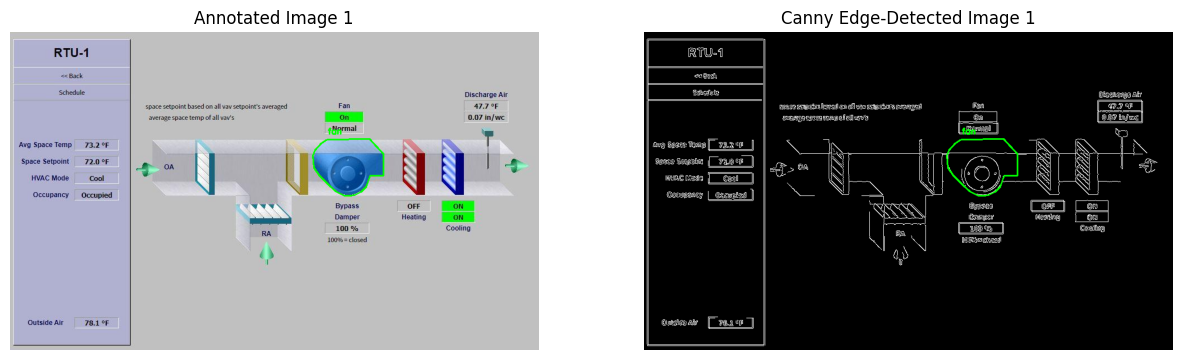

In [23]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the directory path
src_directory = r'C:\Users\bbartling\Desktop\HVACGraphicsClassifier\data\ahu'

# Function to load data with annotations
def load_data_with_annotations(src_dir):
    images = []
    annotations = []

    for root, dirs, files in os.walk(src_dir):
        for file in files:
            if file.endswith('.json'):
                json_path = os.path.join(root, file)
                with open(json_path, 'r') as f:
                    annotation_data = json.load(f)

                img_file = file.replace('.json', '.JPG')
                img_path = os.path.join(root, img_file)

                if not os.path.exists(img_path):
                    continue

                # Load image
                img = load_img(img_path)
                img_cv2 = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

                # Store images and annotations
                images.append(img_cv2)
                annotations.append(annotation_data['shapes'])

    return images, annotations

images, annotations = load_data_with_annotations(src_directory)

# Function to draw polygons on image
def draw_annotations(img, annotations):
    for annotation in annotations:
        label = annotation.get('label', 'N/A')
        points = np.array(annotation['points'], dtype=np.int32)
        points = points.reshape((-1, 1, 2))

        cv2.polylines(img, [points], isClosed=True, color=(0, 255, 0), thickness=2)
        x, y = points[0][0]
        cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    return img

# Function to process images with annotations and Canny edge detection
def process_images_with_annotations_and_canny(images, annotations):
    processed_images = []
    canny_images = []

    for i in range(len(images)):
        original_img = images[i].copy()
        annotated_img = draw_annotations(original_img.copy(), annotations[i])

        # Apply Canny edge detection
        gray = cv2.cvtColor(original_img, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(gray, 100, 200)
        edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        edges_annotated = draw_annotations(edges_colored.copy(), annotations[i])

        processed_images.append(annotated_img)
        canny_images.append(edges_annotated)

        plt.figure(figsize=(15, 15))

        # Display the original image with annotations
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Annotated Image {i+1}")
        plt.axis('off')

        # Display the Canny edge-detected image with annotations
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(edges_annotated, cv2.COLOR_BGR2RGB))
        plt.title(f"Canny Edge-Detected Image {i+1}")
        plt.axis('off')

        plt.show()

    return processed_images, canny_images

processed_images, canny_images = process_images_with_annotations_and_canny(images, annotations)




In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Preprocess images for EfficientNetB0
original_images = tf.keras.applications.efficientnet.preprocess_input(processed_images)
canny_images = tf.keras.applications.efficientnet.preprocess_input(canny_images)

def create_model(input_shape, num_classes):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    for layer in base_model.layers:
        layer.trainable = False
        
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def plot_history(history, title_suffix):
    plt.figure(figsize=(12, 4))
    
    # Plot training & validation loss values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss {title_suffix}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy {title_suffix}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.show()

# Split data into training and validation sets if data is loaded
if len(original_images) > 0 and len(canny_images) > 0:
    # Assuming `labels` and `class_names` are already defined
    # Split data into training and validation sets for original images
    X_train_orig, X_val_orig, y_train, y_val = train_test_split(original_images, labels, test_size=0.2, random_state=42)
    
    # Split data into training and validation sets for Canny images
    X_train_canny, X_val_canny, _, _ = train_test_split(canny_images, labels, test_size=0.2, random_state=42)

    # Define ImageDataGenerator with augmentation for training data
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    val_datagen = ImageDataGenerator()

    # Create data generators for original images
    train_generator_orig = train_datagen.flow(X_train_orig, y_train, batch_size=32)
    val_generator_orig = val_datagen.flow(X_val_orig, y_val, batch_size=32)

    # Create and train the model for original images
    input_shape = (224, 224, 3)
    num_classes = len(class_names)
    model_orig = create_model(input_shape, num_classes)
    history_orig = model_orig.fit(train_generator_orig, validation_data=val_generator_orig, epochs=20)
    model_orig.save(r'C:\Users\bbartling\Desktop\HVACGraphicsClassifier\models\hvac_classifier_efficientnet_original.keras')

    # Plot the training history for original images
    plot_history(history_orig, " (Original)")

    # Create data generators for Canny images
    train_generator_canny = train_datagen.flow(X_train_canny, y_train, batch_size=32)
    val_generator_canny = val_datagen.flow(X_val_canny, y_val, batch_size=32)

    # Create and train the model for Canny images
    model_canny = create_model(input_shape, num_classes)
    history_canny = model_canny.fit(train_generator_canny, validation_data=val_generator_canny, epochs=20)
    model_canny.save(r'C:\Users\bbartling\Desktop\HVACGraphicsClassifier\models\hvac_classifier_efficientnet_canny.keras')

    # Plot the training history for Canny images
    plot_history(history_canny, " (Canny)")

else:
    print("No images found in the specified directory.")


In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to apply Canny edge detection
def apply_canny_edge_detection(img_array):
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 100, 200)
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    return edges_colored

# Function to load and preprocess an image with or without Canny edge detection
def load_and_preprocess_image(image_path, apply_canny=False, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    if apply_canny:
        img_array = apply_canny_edge_detection(img_array)
    img_array = tf.keras.applications.efficientnet.preprocess_input(img_array)
    return np.expand_dims(img_array, axis=0)  # Add batch dimension

# Function to predict the class of an image
def predict_image(model, image_path, class_names, apply_canny=False):
    img_array = load_and_preprocess_image(image_path, apply_canny=apply_canny)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_label = class_names[predicted_class]
    return predicted_label, predictions[0]

# Function to display an image with bounding boxes
def display_image_with_boxes(image_path, predicted_label, annotation_data):
    img = load_img(image_path)
    img_array = img_to_array(img) / 255.0  # Rescale the image
    fig, ax = plt.subplots(1)
    ax.imshow(img_array)

    # Draw bounding boxes from annotation data
    for annotation in annotation_data:
        if annotation['label'] == predicted_label:
            points = np.array(annotation['points'], dtype=np.int32)
            points = points.reshape((-1, 1, 2))
            cv2.polylines(img_array, [points], isClosed=True, color=(0, 255, 0), thickness=2)
            x, y = points[0][0]
            plt.text(x, y, annotation['label'], color='white', fontsize=12, bbox=dict(facecolor='red', alpha=0.5))
    
    plt.show()

# Load the trained models
model_path_original = r'C:\Users\bbartling\Desktop\HVACGraphicsClassifier\models\hvac_classifier_efficientnet_original.keras'
model_path_canny = r'C:\Users\bbartling\Desktop\HVACGraphicsClassifier\models\hvac_classifier_efficientnet_canny.keras'
model_original = tf.keras.models.load_model(model_path_original)
model_canny = tf.keras.models.load_model(model_path_canny)

# Class names from training
# This variable is already loaded in previous cells and should be reused
# class_names = ["min_oa_air_duct", "mixing_air_duct", "return_fan", "outside_air_duct", "return_air_duct", "afms", "air_flow_station", "exhaust_fan", "erv_wheel", "sensor", "heat_coil", "exhaust_air_duct", "cooling_coil", "cool_coil", "supply_air_duct", "damper", "supply_fan"]

# Directory containing test images
test_images_dir = r'C:\Users\bbartling\Desktop\HVACGraphicsClassifier\data\test_images'

# Dictionary to store predictions and annotations
predictions_and_annotations = {}

# Predict each image in the test directory for both models
for img_file in os.listdir(test_images_dir):
    if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(test_images_dir, img_file)

        # Predict with original model
        predicted_label_orig, prediction_scores_orig = predict_image(model_original, img_path, class_names, apply_canny=False)
        print(f"Image: {img_file} (Original)")
        print(f"Predicted Label: {predicted_label_orig}")
        print(f"Prediction Scores: {prediction_scores_orig}\n")

        # Predict with Canny model
        predicted_label_canny, prediction_scores_canny = predict_image(model_canny, img_path, class_names, apply_canny=True)
        print(f"Image: {img_file} (Canny)")
        print(f"Predicted Label: {predicted_label_canny}")
        print(f"Prediction Scores: {prediction_scores_canny}\n")

        # Assuming the annotations are stored in memory in the same format as the previous cell
        # You can modify this according to how you store annotations in memory
        annotations = [
            {
                "label": predicted_label_orig, 
                "coordinates": {"x": 100, "y": 100, "width": 50, "height": 50}  # Example coordinates
            }
        ]
        
        # Store the results for both versions
        predictions_and_annotations[img_file] = {
            "predicted_label_orig": predicted_label_orig,
            "prediction_scores_orig": prediction_scores_orig,
            "predicted_label_canny": predicted_label_canny,
            "prediction_scores_canny": prediction_scores_canny,
            "annotations": annotations
        }

# Display each image with bounding boxes for both versions
for img_file, data in predictions_and_annotations.items():
    img_path = os.path.join(test_images_dir, img_file)
    predicted_label_orig = data['predicted_label_orig']
    predicted_label_canny = data['predicted_label_canny']
    annotations = data['annotations']

    print(f"Displaying image: {img_file} with original prediction")
    display_image_with_boxes(img_path, predicted_label_orig, annotations)

    print(f"Displaying image: {img_file} with Canny prediction")
    display_image_with_boxes(img_path, predicted_label_canny, annotations)
